In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import random
from sklearn.utils import resample
import itertools
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import random
import multiprocessing as mp
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.random_projection import SparseRandomProjection
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron
from matplotlib import pyplot as plt
pd.options.display.max_columns = 150
pd.options.display.max_rows = 3500

In [2]:
# Allow parallel processing for hyperparameter tuning
def parallel(fn, params, n_jobs=mp.cpu_count()):
    pool = mp.Pool(n_jobs)
    print('Started new process pool with {} processes'.format(n_jobs))
    try:
        res = pool.map(fn, params)
        pool.close()
        pool.join()
    except:
        print('Process pool interrupted; shutting down')
        pool.terminate()
        pool.join()
        raise
    return res

In [3]:
# Data Import and cleaning
df = pd.read_csv("/Users/mchifala/Desktop/CSCI_5802/election_dataframe.csv")
df.set_index(['State','FIPS Code'], inplace = True)
df.sort_index(inplace = True)
df.drop([('SD', 46102),('MT', 30113),('VA', 51515),('VA', 51560)], inplace = True)
df.drop(columns=['County','Republicans 2016','Democrats 2016', 'Area name', 'Area_Name','POV05_2016','CI90LB05_2016','CI90UB05_2016','PCTPOV05_2016','CI90LB05P_2016','CI90UB05P_2016'], inplace = True)
df.fillna(df.mean(), inplace = True)
df.dropna(axis='rows', inplace = True)
print(np.shape(df))
classification = {'Democrat': 1,'Republican': -1} 
df['Classification'] = [classification[item] for item in df.Classification] 

# Upsampling the Democratic counties to match the number of Republican counties
df_majority = df[df.Classification== -1]
df_minority = df[df.Classification==1]
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=123) 
df = pd.concat([df_majority, df_minority_upsampled])
df.Classification.value_counts()

# Split the data into test/train sets
train, test = train_test_split(df, test_size = 0.2)
y_train = train['Classification'].values
y_test = test['Classification'].values
X_train = train.loc[:, train.columns != 'Classification'].values
X_test = test.loc[:, test.columns != 'Classification'].values


(3113, 116)


/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "


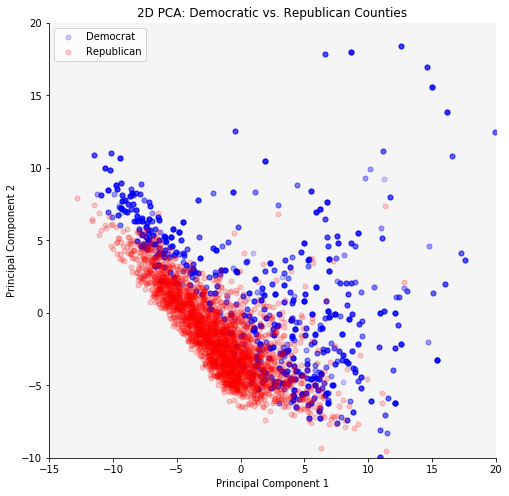

In [4]:
# 2D PCA and graph
X_df = df.loc[:, df.columns != 'Classification'].values
y_df = df.loc[:, ['Classification']]
X_std = StandardScaler().fit_transform(X_df)
principal_components = PCA(n_components=2).fit_transform(X_std)
principal_df = pd.DataFrame(data = principal_components, columns = ['Principal Component 1', 'Principal Component 2'])
final_df = pd.concat([principal_df, y_df.reset_index()], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.grid(False)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('2D PCA: Democratic vs. Republican Counties')
targets = [1, -1]
colors = ['b','r']
for target, color in zip(targets,colors):
    indicesToKeep = final_df['Classification'] == target
    ax.scatter(final_df.loc[indicesToKeep, 'Principal Component 1']
               , final_df.loc[indicesToKeep, 'Principal Component 2']
               , c = color, alpha = 0.2
               , s = 25)
ax.set_ylim(-10,20)
ax.set_xlim(-15,20)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
ax.legend(targets, labels = ['Democrat', 'Republican'])
ax.set_facecolor('#f5f5f5')

/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:1270: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword arguments, some "


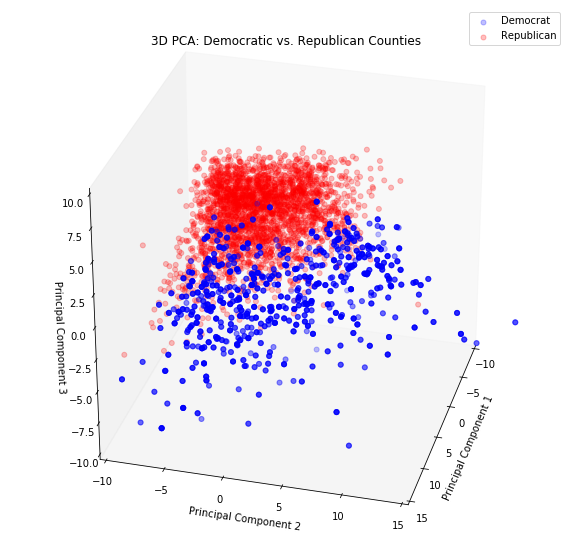

In [5]:
# 3D PCA and graph
X_df = df.loc[:, df.columns != 'Classification'].values
y_df = df.loc[:, ['Classification']]
X_std = StandardScaler().fit_transform(X_df)
principal_components = PCA(n_components=3).fit_transform(X_std)
principal_df = pd.DataFrame(data = principal_components, columns = ['Principal Component 1', 'Principal Component 2', 'Principal Component 3'])
final_df = pd.concat([principal_df, y_df.reset_index()], axis = 1)

fig = plt.figure(figsize = (10,10))
ax = fig.gca(projection = '3d')
ax.grid(False)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA: Democratic vs. Republican Counties')
targets = [1, -1]
colors = ['b','r']
for target, color in zip(targets,colors):
    indicesToKeep = final_df['Classification'] == target
    ax.scatter(final_df.loc[indicesToKeep, 'Principal Component 1']
               , final_df.loc[indicesToKeep, 'Principal Component 2'], final_df.loc[indicesToKeep, 'Principal Component 3']
               , c = color, alpha = 0.25
               , s = 25)
ax.set_ylim(-10,15)
ax.set_xlim(-10,15)
ax.set_zlim(-10,10)
ax.legend(targets, labels = ['Democrat', 'Republican'])
ax.view_init(30, 15)


In [4]:
class TreeNode:
    def __init__(self):
        self.left = None
        self.right = None
        self.isLeaf = False
        self.label = None
        self.split_vector = None
        self.height = 0

    def getLabel(self):
        if not self.isLeaf:
            raise Exception("Should not to do getLabel on a non-leaf node")
        return self.label
    
class RandomDecisionTree:
            
    def __init__(self, candidate_splits = 100, max_depth = 10):
        """
        Args:
            candidate_splits (int) : number of random decision splits to test
            depth (int) : maximum depth of the random decision tree
        """
        self.candidate_splits = candidate_splits
        self.max_depth = max_depth
        self.root = None
        self.height = 0
    
    def fit(self, X_train, y_train):
        """
        Args:
            X_train (ndarray): [n_samples x n_features] ndarray of training data   
            y_train (ndarray): [n_samples] ndarray of data
            
        """
        #print("Building new tree!")
        self.root = self.build_tree(X_train[:], y_train[:], 0)
        return self
        
    def build_tree(self, X_train, y_train, height):
        """
        Args:
            X_train (ndarray): [n_samples x n_features] ndarray of training data   
            y_train (ndarray): [n_samples] ndarray of data
            
        """
    
        #print("Building new node at height", height)
        node = TreeNode()
        
        if height == self.max_depth:
            node.label = self.majority(y_train)
            node.isLeaf = True
            #print("Max depth reached. Classification value:",node.label)
            return node
        
        else:
            node.split_vector = self.find_best_split(X_train,y_train)
            
            if np.any(node.split_vector == False):
                node.label = self.majority(y_train)
                node.isLeaf = True
                #print("Reached a leaf. Classification value:", node.label)
                return node
            else:
                X_positive, y_positive, X_negative, y_negative = self.partition(X_train, y_train, node.split_vector)
                height += 1 
                #print("Left Branch:")
                node.left = self.build_tree(X_negative, y_negative, height)
                #print("Right Branch:")
                node.right = self.build_tree(X_positive, y_positive, height)
               
        return node
    
    def find_best_split(self, X_train, y_train):
        """
        Args:
            X_train (ndarray): [n_samples x n_features] ndarray of training data   
            y_train (ndarray): [n_samples] ndarray of data
            
        """
        split_vector = False
        benefit_of_split = 0
        
        for s in range(0, self.candidate_splits):
            random_vector = np.random.normal(0,1,X_train.shape[1])
        
            X_positive, y_positive, X_negative, y_negative = self.partition(X_train, y_train, random_vector)
            
            #See Lecture 4, Slide 14 for Benefit of Split Equation
            uL = self.gini_index(y_negative)
            uR = self.gini_index(y_positive)
            pL = (len(X_negative)/len(X_train))
            pR = (len(X_positive)/len(X_train))
            uT = self.gini_index(y_train)
            T = len(X_train)
            benefit = (uT - (pL*uL + pR*uR))*T
            
            if (benefit > benefit_of_split):
                split_vector = random_vector
                benefit_of_split = benefit
                #print("Benefit after",s,"splits: ", str(benefit_of_split))
            
        return split_vector
              
    def gini_index(self, y):
        """
        Args:
            y (ndarray): [n_samples] ndarray of data
        """
        
        from collections import Counter
        
        counts = {}
        counts = dict(Counter(y))
        pi_squared =  0
        for key in counts:
            pi_squared += (counts[key]/len(y))**2
        
        return 1 - pi_squared
    
    def partition(self, X_train, y_train, split_vector):
        
        dot_products = np.sign(np.dot(X_train,split_vector))
        X_positive = X_train[np.where(dot_products >= 0)[0]]
        y_positive = y_train[np.where(dot_products >= 0)[0]]
        X_negative = X_train[np.where(dot_products < 0)[0]]
        y_negative = y_train[np.where(dot_products < 0)[0]]
        
        return X_positive, y_positive, X_negative, y_negative
    
    def majority(self, y):
        """
        Return the major class in ndarray y
        """
        
        majority = Counter(y).most_common()
        if (len(majority) == 1):
            return majority[0][0]
        
        elif (majority[0][1]) == majority[1][1]:
            return random.choice([-1,1])
        
        else:
            return majority[0][0]
    
    def predict(self, X):
        """        
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
            
        Returns:
            yhat (ndarray): [n_samples] ndarray of predicted labels {-1,1}
        """
        
        node = self.root
        y_hat = []
        for sample in X:
            node = self.root
            while node.isLeaf == False:
                dot_product = np.sign(np.dot(sample,node.split_vector))
                if (dot_product >= 0):
                    #print("Going Right")
                    node = node.right
                else:
                    #print("Going Left")
                    node = node.left

            #print("Reached Leaf")
            y_hat.append(node.getLabel())                       
        return y_hat

In [5]:
class RandomForest():
    def __init__(self, N = 100, max_depth = 10, candidate_splits = 100, ratio = 0.2, ):
        self.ratio = ratio
        self.N = N
        self.learners = []
        self.candidate_splits = candidate_splits
        self.max_depth = max_depth
        
    def predict(self, X):
        """
        Args:
            X (ndarray): [n_samples x n_features] ndarray of data 
    
        Returns:
            yhat (ndarray): [n_samples] ndarray of predicted labels {-1,1}
        """
        y_hat = []
        for n in range(0,self.N):
            y_hat.append(self.learners[n].predict(X))
       
        vote = self.voting(y_hat)
    
        return vote
    
    def voting(self, y_hats):
        """
        Args:
            y_hats (ndarray): [N] ndarray of data
        Returns:
            y_final : int, final prediction of the 
        """
        from collections import Counter
        import random
        
        vote = []
        y_hats = np.array(y_hats)
        
        for column in range(len(y_hats[0])):
            classes = Counter(y_hats[:,column])
            max_frequency = classes.most_common(1)[0][1]
            
            class_label = [k for k, v in classes.items() if v == max_frequency]
            vote.append((random.choice(class_label)))
        
        return np.reshape(vote,-1)
        
    def bootstrap(self, X_train, y_train):
        """
        Args:
            n (int): total size of the training data
            X_train (ndarray): [n_samples x n_features] ndarray of training data   
            y_train (ndarray): [n_samples] ndarray of data 
        """
        idx = np.random.choice(len(X_train),round(len(X_train)*self.ratio), replace = True)
        bootstrap_X = X_train[idx]
        bootstrap_y = y_train[idx]
        return bootstrap_X, bootstrap_y
    
    def fit(self, X_train, y_train):
        """
        Args:
            X_train (ndarray): [n_samples x n_features] ndarray of training data   
            y_train (ndarray): [n_samples] ndarray of data 
        """

        for n in range(0,self.N):
            classifier = RandomDecisionTree()  
            classifier.N = self.N
            classifier.candidate_splits = self.candidate_splits
            classifier.max_depth = self.max_depth
            bootstrap_X, bootstrap_y = self.bootstrap(X_train, y_train)
            self.learners.append(classifier.fit(bootstrap_X, bootstrap_y))
            
        return
        

In [ ]:
# My testing environment for Random Decision Tree:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import RandomizedSearchCV

max_depth = [None]
candidate_splits = [250]

params = list(itertools.product(max_depth, candidate_splits))
random.shuffle(params)
params = params[0:20]

hyper_tree = {}
for p in params:
    average_acc = 0
    for train_index, valid_index in KFold(n_splits=5).split(X_train,y_train):
        X_cv_train, X_valid = X_train[train_index], X_train[valid_index]
        y_cv_train, y_valid = y_train[train_index], y_train[valid_index]
        tree = RandomDecisionTree(max_depth = p[0], candidate_splits = p[1])
        tree.fit(X_cv_train, y_cv_train)
        y_pred = tree.predict(X_valid)
        average_acc+=accuracy_score(y_valid,y_pred)
    print(average_acc/5)
    hyper_tree[p] = average_acc/5

In [ ]:
print(max(hyper_tree, key=hyper_tree.get))
print(hyper_tree)

In [ ]:
final_tree = RandomDecisionTree(max_depth = 20, candidate_splits = 250)
final_tree.fit(X_train, y_train)
y_pred = final_tree.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test,y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test,y_pred))

In [ ]:
final_forest = RandomForest(max_depth = 20, candidate_splits = 250, ratio = 0.8, N = 250)
final_forest.fit(X_train, y_train)
y_pred = final_tree.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test,y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test,y_pred))

In [ ]:
baseline = Perceptron().fit(X_train, y_train)
baseline_pred = baseline.predict(X_test)
print("Perceptron Accuracy:", accuracy_score(y_test,baseline_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test,baseline_pred))

In [8]:
# Set up parallel processing for forest hyperparameter turning
def forest(X_df, y_df, N, max_depth, ratio, candidate_splits):
    hyper_forest = {}
    for p in params:
        average_acc = 0
        for train_index, valid_index in KFold(n_splits=5).split(X_train,y_train):
            X_cv_train, X_valid = X_train[train_index], X_train[valid_index]
            y_cv_train, y_valid = y_train[train_index], y_train[valid_index]
            forest = RandomForest(N = p[0], max_depth = p[1], candidate_splits = p[2], ratio = p[3])
            forest.fit(X_cv_train, y_cv_train)
            y_pred = forest.predict(X_valid)
            average_acc+=accuracy_score(y_valid,y_pred)
        print(average_acc/5)
        hyper_forest[p] = average_acc/5
    
def run_forest(p):
    n,m,c,r = p
    return forest(X_train, y_train, N = n, max_depth = m, candidate_splits = c, ratio =5)

In [ ]:
# My testing environment for Random Decision Forest
ratio = [0.6, 0.8]
max_depth = [15, 20, 25, None]
candidate_splits = [100, 250]
N = [100, 250] 

params = list(itertools.product(N, max_depth, candidate_splits, ratio))
random.shuffle(params)
params = params[0:50]

cv_forest = parallel(run_forest,params)

Started new process pool with 4 processes
0.9604761904761905
0.9604761904761905
0.9602380952380953
0.9595238095238094
